In [36]:

from PIL import Image, ImageOps
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import torch.backends.cudnn as cudnn
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum
import os
from typing import List, Tuple
import rasterio
import rasterio.plot
import math
import time
import gc

cudnn.benchmark = True

In [37]:
gc.collect()
torch.cuda.empty_cache()

In [38]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [39]:
class_names =   ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']
classes = list(range(len(class_names)))
class_dict = {name: i for i, name in enumerate(class_names)}

In [40]:
weights = EfficientNet_V2_S_Weights.DEFAULT

In [41]:
model = efficientnet_v2_s(weights)

for param in model.parameters(): #freeze model
    param.requires_grad = False

model.classifier[1] = nn.Linear(1280, len(classes))
model = model.to(device)
print(model.classifier)

c:\Users\erikw\anaconda3\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)


In [42]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)

In [43]:
batch_size = 16

In [44]:
summary(
    model,
    input_size=(batch_size, 3, 300, 300),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 300, 300]    [16, 5]              --                   Partial
├─Sequential (features)                                      [16, 3, 300, 300]    [16, 1280, 10, 10]   --                   False
│    └─Conv2dNormActivation (0)                              [16, 3, 300, 300]    [16, 24, 150, 150]   --                   False
│    │    └─Conv2d (0)                                       [16, 3, 300, 300]    [16, 24, 150, 150]   (648)                False
│    │    └─BatchNorm2d (1)                                  [16, 24, 150, 150]   [16, 24, 150, 150]   (48)                 False
│    │    └─SiLU (2)                                         [16, 24, 150, 150]   [16, 24, 150, 150]   --                   --
│    └─Sequential (1)                                        [16, 24, 150, 150]   [16, 

In [45]:
data_dir = 'data'
dataset_dir = os.path.join(data_dir, 'dataset')

In [46]:
class DatasetType(str, Enum):
    TRAINING = 'training'
    VALIDATION = 'validation'
    TEST = 'test'

class AimlsseImageDataset(Dataset):
    def __init__(self, type:DatasetType, dataset_dir:str, bands:List[str], station_radius:float,
                 transfrom=None, target_transform=None) -> None:
        super().__init__()
        self.bands_metadata = pd.read_csv(os.path.join(dataset_dir, f'bands_metadata.csv'))
        self.bands_metadata.set_index('band', inplace=True)
        bands_series = pd.Series(bands)
        invalid_bands = bands_series[~bands_series.isin(self.bands_metadata.index)].to_list()
        if any(invalid_bands):
            raise ValueError(f'Bands {invalid_bands} are not valid')
        if len(self.bands_metadata.loc[bands]['resolution [M]'].unique()) != 1:
            raise ValueError(f'Bands {bands} do not have the same resolution')
        self.bands = bands
        self.station_radius = station_radius
        self.img_labels = pd.read_csv(os.path.join(dataset_dir, f'{type.value}_labels.csv'))
        self.img_dir = os.path.join(dataset_dir, type.value)
        self.transform = transfrom
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index) -> Tuple[np.ndarray, str]:
        img_paths = [os.path.join(self.img_dir, self.img_labels.iloc[index]['dir'], f'{band}.jp2') for band in self.bands]
        images = [rasterio.open(path) for path in img_paths]
        image_tensors: List[np.ndarray] = [img.read(1).astype(np.float32) / 10000 for img in images]
        [img.close() for img in images]
        # Resize images with small size-differences to make them stackable
        image_side_length = int(1 + math.floor(2.0 * self.station_radius / float(self.bands_metadata.loc[self.bands].iloc[0]['resolution [M]'])))
        new_shape = (image_side_length, image_side_length)
        [img.resize(new_shape, refcheck=False) for img in image_tensors]
        # Stack images into final image, select label and perform transformations
        image_tensors_stacked = np.stack(image_tensors, axis=2)
        label = class_dict[self.img_labels.iloc[index]['max cloud cover']]
        if self.transform:
            image_tensors_stacked = self.transform(image_tensors_stacked)
        if self.target_transform:
            label = self.target_transform(label)
        return image_tensors_stacked, label

In [47]:
composed_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300), interpolation=transforms.InterpolationMode.BICUBIC)
])

In [48]:
bands = ['B4', 'B3', 'B2']
station_radius = 8000.0
train_dataset = AimlsseImageDataset(DatasetType.TRAINING,           dataset_dir, bands, station_radius, transfrom=composed_transforms)
validation_dataset = AimlsseImageDataset(DatasetType.VALIDATION,    dataset_dir, bands, station_radius, transfrom=composed_transforms)
test_dataset = AimlsseImageDataset(DatasetType.TEST,                dataset_dir, bands, station_radius, transfrom=composed_transforms)

In [49]:
train_dataloader =      DataLoader(train_dataset,       batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,  batch_size=batch_size, shuffle=True)
test_dataloader =       DataLoader(test_dataset,        batch_size=batch_size, shuffle=True)

In [35]:
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
print(inputs.shape, [class_names[c] for c in classes.unique().numpy()])

KeyboardInterrupt: 

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
out.shape

torch.Size([3, 606, 2418])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


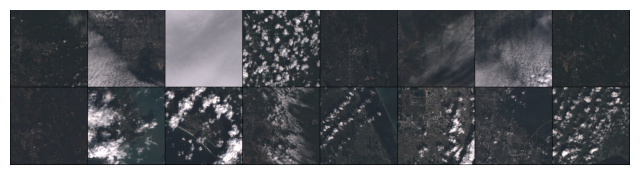

[['CLR', 'OVC', 'OVC', 'CLR', 'CLR', 'CLR', 'BKN', 'SCT'],
 ['CLR', 'BKN', 'BKN', 'BKN', 'SCT', 'BKN', 'FEW', 'BKN']]

In [ ]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def imshow(inp: torch.Tensor, title=None):
    """Imshow for Tensor."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')
    ax.imshow(inp.permute(1, 2, 0))
    plt.pause(0.001)  # pause a bit so that plots are updated

imshow(out)

list(chunks([class_names[c] for c in classes.numpy()], 8))

In [50]:
import copy


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataset = train_dataset
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataset = validation_dataset
                dataloader = validation_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataset)
            epoch_acc = running_corrects.double() / len(dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [51]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [53]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3678 Acc: 0.4433
val Loss: 1.3052 Acc: 0.5060

Epoch 1/24
----------
train Loss: 1.2866 Acc: 0.4854
val Loss: 1.3144 Acc: 0.4836

Epoch 2/24
----------
train Loss: 1.2694 Acc: 0.5022
val Loss: 1.2881 Acc: 0.4836

Epoch 3/24
----------


KeyboardInterrupt: 